In [1]:
import numpy as np
import time
import sys
import os
import tqdm

import torch
from torch import nn
import torch.nn.functional as F


from catr.configuration import Config
from catr.models.utils import NestedTensor, nested_tensor_from_tensor_list, get_rank
from catr.models.backbone import build_backbone
from catr.models.transformer import build_transformer
from catr.models.position_encoding import PositionEmbeddingSine
from catr.models.caption import MLP

import json

from dataset.dataset import ImageFeatureDataset
from torch.utils.data import DataLoader
from transformer_ethan import *
sys.path.append(os.path.join(os.path.dirname("__file__"), "catr"))
from engine import train_one_epoch, evaluate

In [4]:
words = np.load("glove_embed.npy")
with open('word2ind.json') as json_file: 
    word2ind = json.load(json_file) 
with open('ind2word.json') as json_file: 
    ind2word = json.load(json_file) 
config = Config()
config.device = 'cpu' # if running without GPU
config.feature_dim = 1024
config.pad_token_id = word2ind["<S>"]
config.hidden_dim = 300
config.nheads = 10
config.batch_size = 8
config.encoder_type = 1
config.vocab_size = words.shape[0]
config.dir = '../mimic_features'
config.__dict__["pre_embed"] = torch.from_numpy(words)

In [5]:
model, criterion = main(config)
model = model.float()
device = torch.device(config.device)
model.to(device)

Initializing Device: cpu
Number of params: 33908144


Xray_Captioner(
  (input_proj): Conv2d(1024, 300, kernel_size=(1, 1), stride=(1, 1))
  (position_embedding): PositionEmbeddingSine()
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): _LinearWithBias(in_features=300, out_features=300, bias=True)
          )
          (linear1): Linear(in_features=300, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=300, bias=True)
          (norm1): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): _LinearWithBias(in_features=3

In [6]:
param_dicts = [
        {"params": [p for n, p in model.named_parameters(
        ) if "backbone" not in n and p.requires_grad]},
        {
            "params": [p for n, p in model.named_parameters() if "backbone" in n and p.requires_grad],
            "lr": config.lr_backbone,
        },
    ]

In [7]:
optimizer = torch.optim.AdamW(
        param_dicts, lr=config.lr, weight_decay=config.weight_decay)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, config.lr_drop)

In [8]:
dataset_train = ImageFeatureDataset(config, mode='train')
dataset_val = ImageFeatureDataset(config, mode='val')

sampler_train = torch.utils.data.RandomSampler(dataset_train)
sampler_val = torch.utils.data.SequentialSampler(dataset_val)

batch_sampler_train = torch.utils.data.BatchSampler(
        sampler_train, config.batch_size, drop_last=True)

data_loader_train = DataLoader(
        dataset_train, batch_sampler=batch_sampler_train, num_workers=config.num_workers)
data_loader_val = DataLoader(dataset_val, config.batch_size,
                                 sampler=sampler_val, drop_last=False, num_workers=config.num_workers)
print(f"Train: {len(dataset_train)}")
print(f"Val: {len(dataset_val)}")

Train: 128
Val: 32


In [9]:
if os.path.exists(config.checkpoint):
     print("Loading Checkpoint...")
     checkpoint = torch.load(config.checkpoint, map_location='cpu')
     model.load_state_dict(checkpoint['model'])
     optimizer.load_state_dict(checkpoint['optimizer'])
     lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
     config.start_epoch = checkpoint['epoch'] + 1

print("Start Training..")

In [13]:
train_loss_hist = []
val_loss_hist = []

for epoch in range(config.start_epoch, config.epochs):
    print(f"Epoch: {epoch}")
    epoch_loss = train_one_epoch(
        model, criterion, data_loader_train, optimizer, device, epoch, config.clip_max_norm)
    train_loss_hist.append(epoch_loss)
    lr_scheduler.step()
    print(f"Training Loss: {epoch_loss}")

    torch.save({
         'model': model.state_dict(),
         'optimizer': optimizer.state_dict(),
         'lr_scheduler': lr_scheduler.state_dict(),
         'epoch': epoch,
     }, config.checkpoint)

    validation_loss = evaluate(model, criterion, data_loader_val, device)
    val_loss_hist.append(validation_loss)
    print(f"Validation Loss: {validation_loss}")

    print()

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 0


  0%|          | 0/16 [00:06<?, ?it/s]


KeyboardInterrupt: 

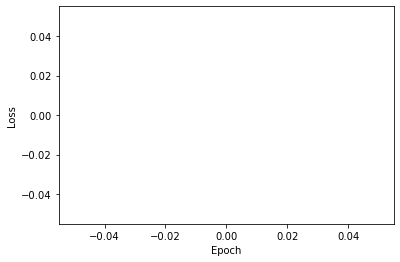

In [14]:
import matplotlib.pyplot as plt
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.grid()
plt.plot(train_loss_hist)

# Evaluation helper funcs

In [15]:
# Edward: note this makes a new caption as (<S>, 0, ..., 0) shouldn't we want as (<S>, <S>, ..., <S>)?
def create_caption_and_mask(start_token, max_length):
    caption_template = torch.zeros((1, max_length), dtype=torch.long)
    mask_template = torch.ones((1, max_length), dtype=torch.bool)

    caption_template[:, 0] = start_token
    mask_template[:, 0] = False

    return caption_template, mask_template

In [16]:
def make_report(captions):
    all_reports = []
    for report in captions:
        if (report == word2ind["</s>"]).any():
            end_index = (report == word2ind["</s>"]).nonzero()[0][0]
            report = report[:end_index+1]
        one_report = list(map(lambda x: ind2word[str(x)], report))
        all_reports.append(one_report)
    return all_reports

def reports_to_sentence(reports):
    return [' '.join(r) for r in make_report(reports)]

In [17]:
def evaluate(images):
    all_captions = []
    model.eval()
    for i in range(len(images)):
        image = images[i:i+1]
        caption, cap_mask = create_caption_and_mask(
            config.pad_token_id, config.max_position_embeddings)
        for i in range(config.max_position_embeddings - 1):
            predictions = model(image, caption, cap_mask)
            predictions = predictions[:, i, :]
            predicted_id = torch.argmax(predictions, axis=-1)


            caption[:, i+1] = predicted_id[0]
            cap_mask[:, i+1] = False
            
            if predicted_id[0] == word2ind["</s>"]:
                break

        all_captions.append(caption.numpy())
#     return make_report(all_captions)
    return all_captions

In [19]:
image, note, note_mask = next(iter(data_loader_train))

In [20]:
report = evaluate(image)

In [21]:
report_np = np.asarray(report).squeeze(1)
reports_to_sentence(report_np)

['<S> " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " "']

In [ ]:
reports_to_sentence(np.asarray(note))

In [ ]:
note.shape

In [ ]:
evaluate(image[0].unsqueeze(0).unsqueeze(0))

In [ ]:
image.unsqueeze(0).shape